In [86]:
import pandas as pd
from scipy import stats
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.sparse as sp
from sklearn.preprocessing import MinMaxScaler

import rpy2
import random
import math
import seaborn as sns
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Path fo import files
#input data
import_data = "import/ecs_series_1_uid_encoded(1).csv"
#generated data
transformed_analyzed_data = 'Export/alibaba/alibaba_initial_time_series_2000.csv'
monetary_time_series = "Export/alibaba/alibaba_monetary_2000.csv"
frequency_time_series = "Export/alibaba/alibaba_frequency_2000.csv"
recency_time_series = "Export/alibaba/alibaba_recency_2000.csv"
cluster_centroids_time_series = "Export/alibaba/alibaba_cluster_centroids_2000.csv"
#prediction
prediction_path = "Export/alibaba/alibaba_prediction_theta_variantA.csv"
#Clusters
import_clusters = "clusters/results_alibaba.csv"

### 0. Preprocessing alibaba + normalizing

In [5]:
df = pd.read_csv(import_data)

In [6]:
# Normalizing
demand = df[['ds', "uid", "vcpu_net_delead"]].\
                    groupby(['ds','uid', "vcpu_net_delead"]).sum().\
                    reset_index()
df['vcpu_net_delead'] = demand[["uid","vcpu_net_delead"]].\
                    groupby(["uid"]).cumsum()

In [7]:
datetime_object = datetime.datetime.strptime("9/27/18 16:00", "%m/%d/%y %H:%M")
df['Date'] = df["ds"].apply(lambda x:datetime.datetime.strptime(x, "%m/%d/%y %H:%M"))
df = df.drop(columns = ['ds','region_no_factor','iz_no_factor','product_factor','instance_type_name_factor','instance_type_family_factor'])
df = df.groupby(by=['uid','Date']).sum().reset_index()
df = df.pivot(columns = 'Date',index = 'uid',values = 'vcpu_net_delead')
df.head()

Date,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
1,-1.000000e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-3.333333e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.086488e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.064878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,-0.084211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 0.1 Choose TS with given clusters and divide into test/train dataset

In [9]:
cluster_TS  = pd.read_csv(import_clusters)
cluster_TS.head()

,Unnamed: 0,clusters_r,clusters_m,clusters_f,supercluster
0,117237,4.0,9.0,0.0,2.0
1,7669,1.0,9.0,0.0,2.0
2,117808,4.0,9.0,0.0,2.0
3,34612,4.0,17.0,0.0,2.0
4,74579,1.0,0.0,0.0,0.0


In [10]:
df_train = cluster_TS.merge(df,left_on = "Unnamed: 0", right_on = 'uid').drop(columns = ['clusters_r','clusters_m','clusters_f','supercluster'])
df_train = df_train.rename(index = str, columns={"Unnamed: 0": "uid"}).set_index('uid')
df_train.head()

,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
117237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_test= df.drop(df_train.index.values,axis=0).sample(600)
df_test.head()

Date,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
122101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### NAN -> 0

In [12]:
df_train = df_train.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_test = df_test.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_train.sample(2)

,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
91547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.023529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into train/test (last 70 days) and scaling

In [17]:
train_targets, test_targets= train_test_split((df_test.append(df_train)).transpose(), test_size=.10, shuffle=False)

In [18]:
test_targets = test_targets.transpose()
train_targets = train_targets.transpose()

In [87]:
#scaling
scl = MinMaxScaler()
train_targets_scaled = scl.fit_transform(train_targets)

## Theta method

In [88]:
from rpy2.robjects.packages import importr
# import R's "base" package
# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
# R package names
packnames = ['forecast']
# R vector of strings
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector('forecast'))
base = importr('forecast')


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### We take test as last 10 weeks (70 days)

In [89]:
%%time
df_prediction = pd.DataFrame(columns = test_targets.columns)
train_targets_scaled = pd.DataFrame(train_targets_scaled)
train_targets_scaled.index = test_targets.index
for index, row in train_targets_scaled.iterrows():
    res = robjects.FloatVector(row.drop(columns = ['uid']))
    r_prediction = base.thetaf(res,70)[1]
    df_prediction.loc[index] = r_prediction

CPU times: user 22.8 s, sys: 0 ns, total: 22.8 s
Wall time: 22.8 s


In [93]:
# Score is better without scl.transform(df_prediction)
print("RMSE score:", round(math.sqrt(mean_squared_error(test_targets,df_prediction)),2))

RMSE score: 1.36


### Save to file

In [94]:
df_prediction.to_csv(prediction_path)
df_prediction.sample(5)

,2018-09-17 16:00:00,2018-09-18 16:00:00,2018-09-19 16:00:00,2018-09-20 16:00:00,2018-09-21 16:00:00,2018-09-22 16:00:00,2018-09-23 16:00:00,2018-09-24 16:00:00,2018-09-25 16:00:00,2018-09-26 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
960,0.351649,0.351872,0.352095,0.352318,0.352541,0.352764,0.352987,0.353210,0.353433,0.353656,...,0.365028,0.365251,0.365474,0.365697,0.365920,0.366143,0.366366,0.366589,0.366812,0.367035
43512,0.351265,0.351492,0.351719,0.351947,0.352174,0.352402,0.352629,0.352856,0.353084,0.353311,...,0.364908,0.365135,0.365363,0.365590,0.365818,0.366045,0.366272,0.366500,0.366727,0.366954
4516,0.351500,0.351726,0.351951,0.352177,0.352403,0.352629,0.352855,0.353081,0.353307,0.353533,...,0.365053,0.365279,0.365505,0.365731,0.365957,0.366183,0.366409,0.366635,0.366860,0.367086
57240,0.351182,0.351409,0.351636,0.351863,0.352091,0.352318,0.352545,0.352772,0.352999,0.353226,...,0.364812,0.365039,0.365267,0.365494,0.365721,0.365948,0.366175,0.366402,0.366630,0.366857
34746,0.351186,0.351413,0.351641,0.351868,0.352095,0.352322,0.352549,0.352776,0.353004,0.353231,...,0.364817,0.365044,0.365271,0.365499,0.365726,0.365953,0.366180,0.366407,0.366634,0.366862


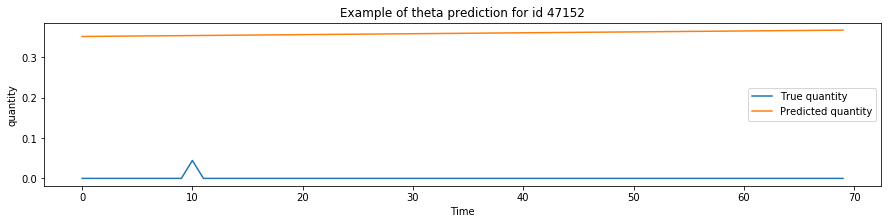

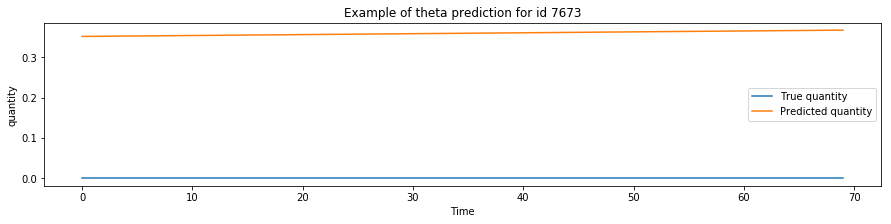

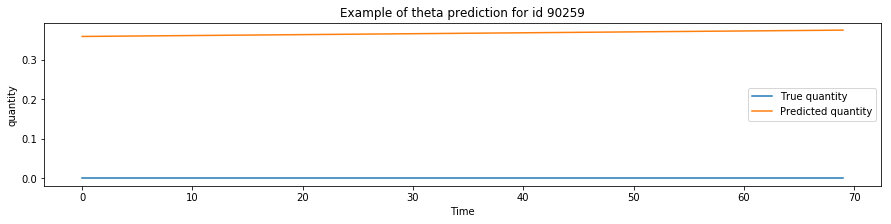

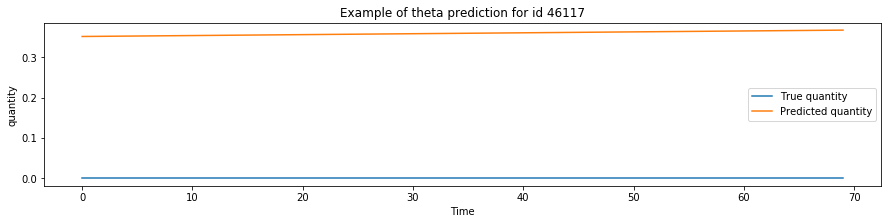

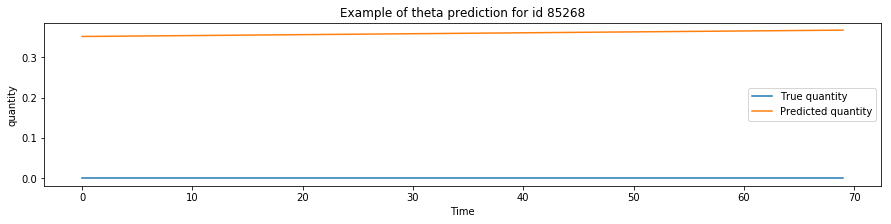

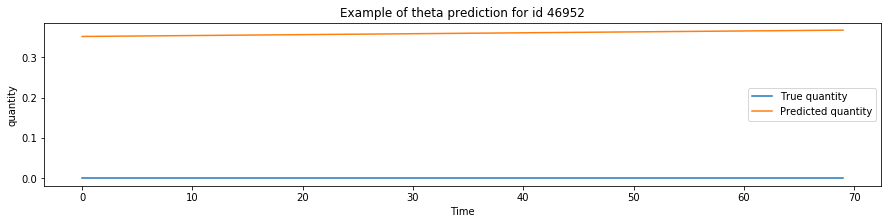

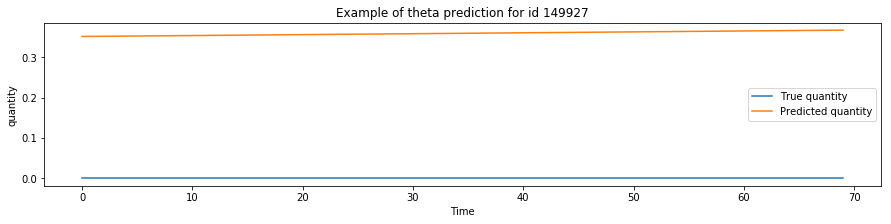

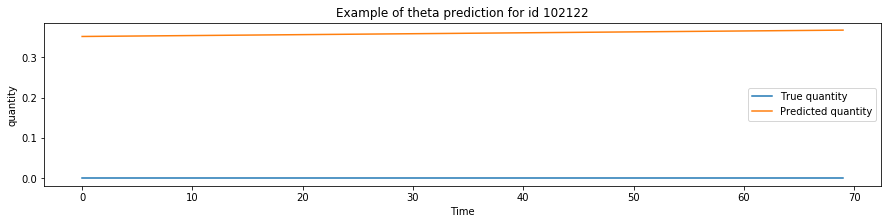

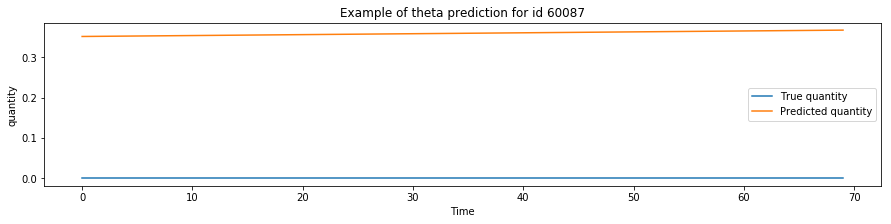

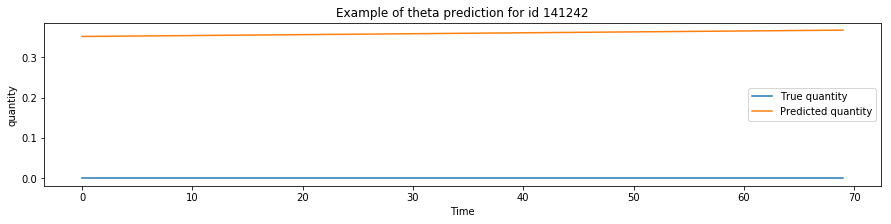

In [95]:
for x in range(10):
    rand = random.choice (test_targets.index)
    fig = plt.figure(figsize=(15,3))
    plt.plot(np.array(test_targets.loc[rand,:]).ravel(), label = 'True quantity')
    plt.plot(np.array(df_prediction.loc[rand,:]).ravel(), label = 'Predicted quantity')
    plt.xlabel('Time')
    plt.ylabel('quantity')
    plt.title('Example of theta prediction for id '+str(rand))
    plt.legend(); 